## Notebook 1 - Análise Exploratória dos Dados

**Objetivo**: Descrever a estrutura dos dados e realizar análises exploratórias com o objetivo de identificar padrões nos dados e relações entre variáveis. Nenhuma alteração nos dados será feita aqui. O tratamento dos dados (limpeza e transformação) será realizado no notebook 2)

---

## 0 - Imports e funções auxiliares

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pyod.models.knn import KNN
warnings.filterwarnings("ignore")

In [3]:
def print_data_structure(data):
    for key, value in data.items():
        print(f"{key}: {value.shape[0]} linhas, {value.shape[1]} colunas")

In [4]:
def calculate_missing_values(data):
    any_missing_cols = [col for col in data.columns if data[col].isnull().any()]
    tot_missing_col = pd.DataFrame(data[any_missing_cols].isnull().sum(), columns=["Total_NA"])
    tot_missing_col["%NA"] = round(tot_missing_col/data.shape[0], 2)
    return tot_missing_col

In [5]:
def make_boxplot_3axis(x, y_list, data):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,5))
    sns.boxplot(x=x, y=y_list[0], data=data, ax=ax1)
    sns.boxplot(x=x, y=y_list[1], data=data, ax=ax2)
    sns.boxplot(x=x, y=y_list[2], data=data, ax=ax3)
    
    ax1.set_ylabel(y_list[0].capitalize())
    ax2.set_ylabel(y_list[1].capitalize())
    ax3.set_ylabel(y_list[2].capitalize())
    
    plt.show()

In [6]:
def make_kdeplot_by_debt(x, df):
    fig = plt.figure(figsize=(10,4))
    ax=sns.kdeplot(df.loc[(df['inadimplente'] == 0),x] , color='b',shade=True,label='Não inadimplente')
    ax=sns.kdeplot(df.loc[(df['inadimplente'] == 1),x] , color='r',shade=True, label='Inadiplente')
    ax.set(xlabel=x, ylabel='Frequencia')
    plt.legend()
    plt.plot();

In [9]:
def remove_outliers_in_last_percentile(variable_list, data, verbose=False):
    df_filtered = data.copy()
    
    for x in variable_list:
        percentile_99 = list(data[x].quantile([.99])[0])
        df_filtered = df_filtered[df_filtered[x] < percentile_99]
        if verbose: print(f"Variável: {x} - Último Percentil: {percentile_99}")
    
    return df_filtered

---

## 1 - Ingestão dos dados

In [10]:
df_train_raw = pd.read_csv("../dados/raw/treino.csv")
df_test_raw = pd.read_csv("../dados/raw/teste.csv")

---

## 2 - Descrição dos dados

### 2.1.Estrutura

In [11]:
print_data_structure({"Dados de Treino": df_train_raw, 
                      "Dados de Teste": df_test_raw})

Dados de Treino: 110000 linhas, 11 colunas
Dados de Teste: 40000 linhas, 10 colunas


Concantenando as bases para ter um conjunto de dados único para exploração:

In [18]:
diff_col_number = sum(df_train_raw.columns[1:] != df_test_raw.columns)
print(f"Há {diff_col_number} colunas diferentes entre as bases de treino e teste!")
if diff_col_number == 0: 
    df_raw = pd.concat([df_train_raw, df_test_raw])

Há 0 colunas diferentes entre as bases de treino e teste!


In [19]:
print_data_structure({"Dados concatenados": df_raw})

Dados concatenados: 150000 linhas, 11 colunas


### 2.2.Tipos de dados

In [20]:
df_raw.dtypes

inadimplente                             float64
util_linhas_inseguras                    float64
idade                                      int64
vezes_passou_de_30_59_dias                 int64
razao_debito                             float64
salario_mensal                           float64
numero_linhas_crdto_aberto                 int64
numero_vezes_passou_90_dias                int64
numero_emprestimos_imobiliarios            int64
numero_de_vezes_que_passou_60_89_dias      int64
numero_de_dependentes                    float64
dtype: object

Não há necessidade de transformar dados, pois os tipos já estão adequados. Também não há necessidade de separar os dados por tipo (variáveis categóricas x numéricas), pois todas as variáveis explicativas são numéricas. Apenas a variável target é binária.

### 2.3.Valores faltantes e Registros duplicados

In [14]:
calculate_missing_values(df_train_raw)

,Total_NA,%NA
salario_mensal,21763,0.20
numero_de_dependentes,2878,0.03


In [15]:
calculate_missing_values(df_test_raw)

,Total_NA,%NA
salario_mensal,7968,0.20
numero_de_dependentes,1046,0.03


É possível perceber que 2 variáveis tem muitos valores faltantes para as bases de treino e teste: salário e número de dependentes. Explorarei melhor a natureza dessas variáveis em tópicos posteriores para tomar uma decisão sobre como tratar esses registros: eliminação ou inputação de valores.

In [14]:
print(f"Há {df_train_raw.duplicated().sum()} registros duplicados na base de treino.")
print(f"Há {df_test_raw.duplicated().sum()} registros duplicados na base de treino.")

Há 363 registros duplicados na base de treino.
Há 71 registros duplicados na base de treino.


---

## 3.Estatística Descritiva

### 3.0.Geral

In [15]:
df_train_raw.describe()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
count,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,8.823700e+04,110000.000000,110000.000000,110000.000000,110000.000000,107122.000000
mean,0.066645,5.929979,52.255636,0.424055,354.823589,6.637411e+03,8.445573,0.269955,1.019891,0.243891,0.757482
std,0.249408,252.301965,14.768241,4.240780,2074.140421,1.338395e+04,5.139026,4.217326,1.135989,4.204137,1.114670
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030054,41.000000,0.000000,0.175016,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.155936,52.000000,0.000000,0.366682,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.562806,63.000000,0.000000,0.866874,8.225000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [21]:
df_test_raw.describe()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
count,40000.000000,40000.000000,40000.000000,40000.000000,3.203200e+04,40000.000000,40000.000000,40000.000000,40000.000000,38954.000000
mean,6.374199,52.404025,0.412725,348.004166,6.760602e+03,8.472525,0.255025,1.013700,0.230750,0.756508
std,242.617247,14.781468,4.057899,1934.436246,1.683639e+04,5.164960,4.034327,1.112494,4.017506,1.116244
min,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029362,41.000000,0.000000,0.175360,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.149491,52.000000,0.000000,0.366172,5.409500e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.549762,63.000000,0.000000,0.872253,8.284000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,22000.000000,109.000000,98.000000,307001.000000,1.794060e+06,57.000000,98.000000,25.000000,98.000000,13.000000


**Distribuições estranhas:**
- Registros com idade mínima = 0
- Registros com linhas inseguras > 1 (100%). Está limitado entre 0 e 1?Se sim, máximo está discrepante
- Razão/débito está limitado entre 0 e 1?Se sim, máximo está discrepante

### 3.1.Variável resposta

#### 3.1.1.Contagem de inadimplentes (balanceamento do target):

In [18]:
debt_rate = pd.DataFrame(df_train_raw["inadimplente"].value_counts())
debt_rate["%inadimplente"] = round(debt_rate.inadimplente/len(df_train_raw),2)
debt_rate

,inadimplente,%inadimplente
0,102669,0.93
1,7331,0.07


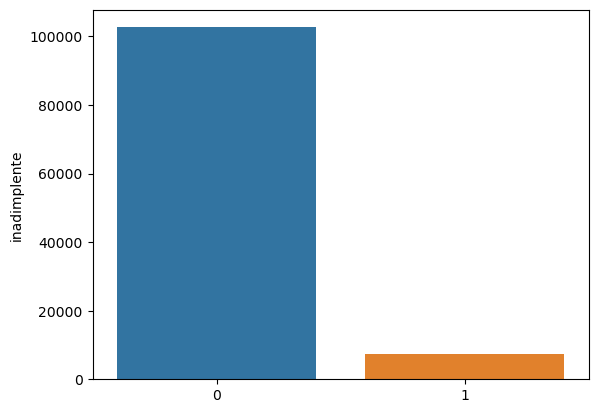

In [19]:
sns.barplot(y="inadimplente", x= debt_rate.index, data=debt_rate);

#### 3.1.2.Média das variáveis por classe de inadimplência

In [20]:
debt_summary = df_train_raw.groupby("inadimplente")
debt_summary.mean().T

inadimplente,0,1
util_linhas_inseguras,6.149973,2.849017
idade,52.706620,45.939708
vezes_passou_de_30_59_dias,0.282919,2.400627
razao_debito,358.444847,304.108675
salario_mensal,6711.243899,5640.437212
numero_linhas_crdto_aberto,8.485853,7.881462
numero_vezes_passou_90_dias,0.139205,2.101078
numero_emprestimos_imobiliarios,1.022363,0.985268
numero_de_vezes_que_passou_60_89_dias,0.129825,1.841359
numero_de_dependentes,0.744593,0.936380


Olhar para a média pode ser útil em alguns casos, porém, esta medida é muito influenciada por outliers. Portanto, é necessário ter alguma cautela na interpretação dos resultados. Sobretudo para as variáveis "linhas inseguras" e "razão débito", que parece ter valores muito discrepantes. Explorando os resultados eliminando valores maiores que 1 para as duas variáveis:

In [21]:
condition1 = df_train_raw["util_linhas_inseguras"] <= 1
condition2 = df_train_raw["razao_debito"] <= 1
debt_summary_filtered = df_train_raw.loc[(condition1) & (condition2)].groupby("inadimplente")
debt_summary_filtered.mean().T

inadimplente,0,1
util_linhas_inseguras,0.293025,0.637391
idade,51.978586,45.943030
vezes_passou_de_30_59_dias,0.305501,2.780000
razao_debito,0.299675,0.347245
salario_mensal,7014.161989,5978.886032
numero_linhas_crdto_aberto,8.659606,7.907071
numero_vezes_passou_90_dias,0.158178,2.489495
numero_emprestimos_imobiliarios,1.012006,0.931919
numero_de_vezes_que_passou_60_89_dias,0.150282,2.248687
numero_de_dependentes,0.830350,1.014581


### 3.2.Variáveis explicativas

#### 3.2.1.Distribuição das variáveis explicativas

Isso é importante para decidir qual será o método de rescalonamento dos dados, se necessário utilizar. Variáveis com distribuição mais próxima da Gaussiana são melhores ajustados com a padronização, ao invés da normalização.  

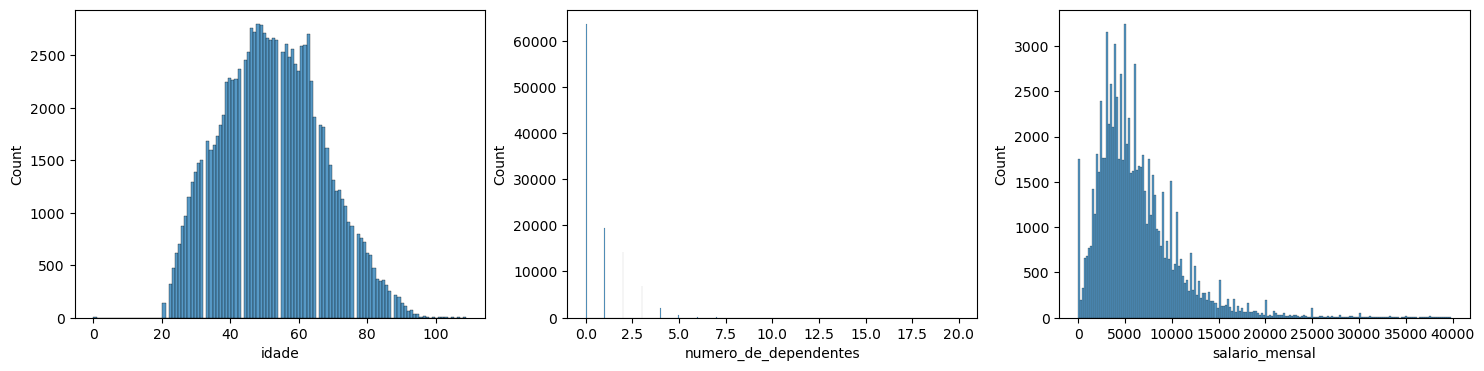

In [9]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,4))
sns.histplot(data=df_train_raw, x="idade",ax=ax1)
sns.histplot(data=df_train_raw, x="numero_de_dependentes",ax=ax2)
sns.histplot(data=df_train_raw[df_train_raw["salario_mensal"]<40000], x="salario_mensal",ax=ax3)
plt.show();

In [ ]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,4))
sns.histplot(data=df_train_raw, x="numero_emprestimos_imobiliarios",ax=ax1)
sns.histplot(data=df_train_raw, x="numero_vezes_passou_90_dias",ax=ax2)
sns.histplot(data=df_train_raw, x="util_linhas_inseguras",ax=ax3)
plt.show();

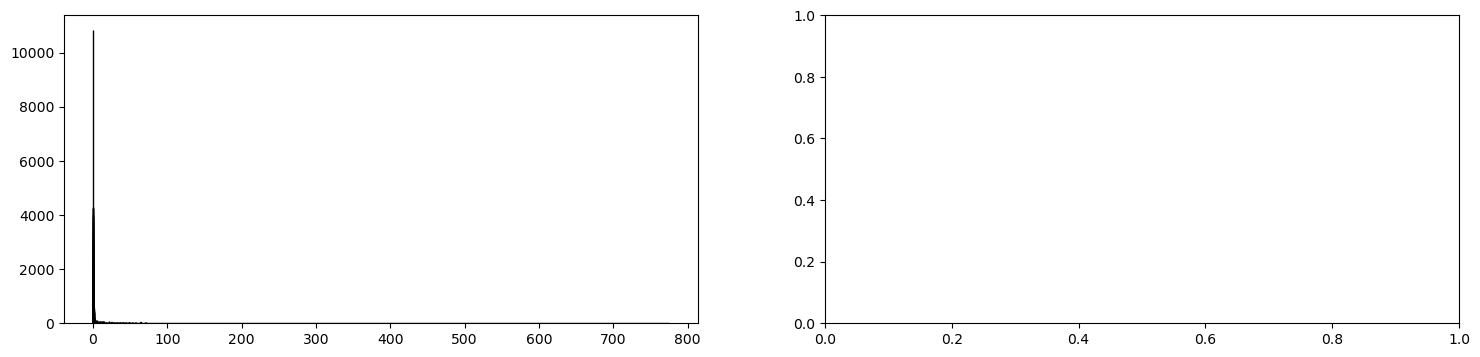

In [23]:
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(18,4))
sns.histplot(data=df_train_raw, x="razao_debito",ax=ax1)
sns.histplot(data=df_train_raw, x="numero_linhas_crdto_aberto",ax=ax2)

#### 3.2.2.Correlação entre as variáveis explicativas

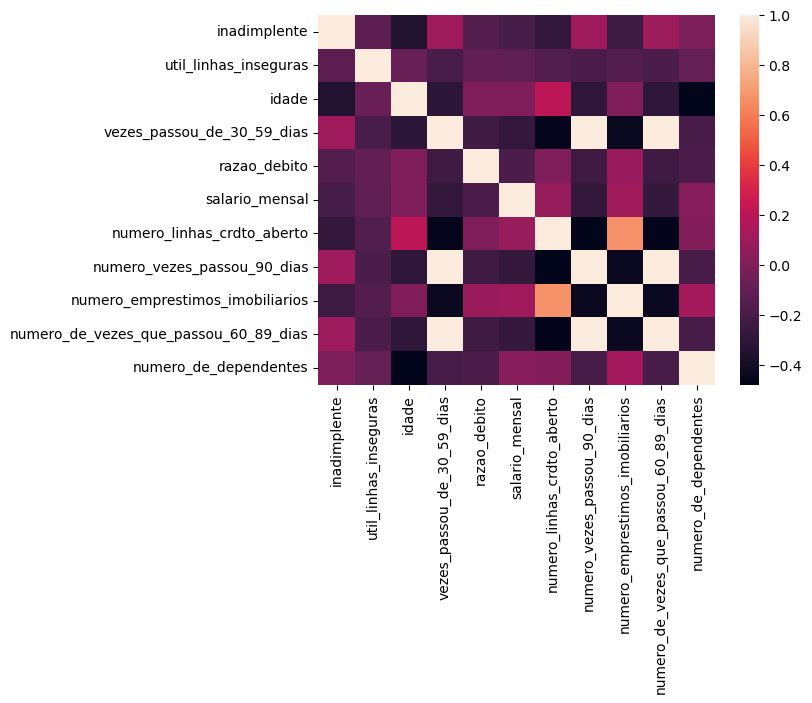

In [21]:
corr = df_raw.corr()
sns.heatmap(corr.corr(), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

Identificando pares de variáveis com alta correlação (> 0.90). Durante a limpeza de dados, as variáveis auto-correlacionadas serão apagadas por serem redundantes e não acrescentarem informações novas para o modelo.

In [24]:
X = df_raw.iloc[:,1:]
threshold_corr = 0.90

matrix_corr = X.corr().abs().unstack().sort_values(ascending=False)
highest_corr_attributes = matrix_corr[(matrix_corr.values > threshold_corr) & (matrix_corr.values != 1)]
highest_corr_attributes

numero_vezes_passou_90_dias            numero_de_vezes_que_passou_60_89_dias    0.992796
numero_de_vezes_que_passou_60_89_dias  numero_vezes_passou_90_dias              0.992796
vezes_passou_de_30_59_dias             numero_de_vezes_que_passou_60_89_dias    0.987005
numero_de_vezes_que_passou_60_89_dias  vezes_passou_de_30_59_dias               0.987005
vezes_passou_de_30_59_dias             numero_vezes_passou_90_dias              0.983603
numero_vezes_passou_90_dias            vezes_passou_de_30_59_dias               0.983603
dtype: float64

### 3.3.Análise bivariada

**Fenômeno estudado**: pagamento de linhas de crédito. Ou seja, o objetivo principal da análise é avaliar o risco de inadimplência dos clientes que querem tomar um empréstimo para que a financeira possa tomar uma decisão sobre liberar ou não o empréstimo.

**Agentes envolvidos no fenômeno**: 
- tomador do empréstimo (cliente)
- empréstimos
- instituição financeira que pode realizar o empréstimo ao cliente

**Atributos dos agentes:**
- **Cliente**: idade, número de dependentes, renda, quantidade de empréstimos em aberto, assiduididade no pagamento de empréstimos, relação entre patrimônio e dívidas.
- **Empréstimos**: atrasos, número, segurança (linhas inseguras)
- **Financeira**: número de empréstimos concedidos

**Lista de hipóteses para explorar:**

- 1.Clientes mais velhos, com maior salário ou com menos dependentes devem ser menos inadimplentes?
- 2.Clientes com mais empréstimos em aberto devem ser menos inadimplentes?
- 3.Clientes que atrasam menos devem ser menos inadimplentes?
- 4.Quando menor a razão dívida/patrimônio, menor a inadimplência?
- 5.Quanto menos linhas seguras, maior a inadimplência?
- 6.Quanto maior a renda, maior o número de empréstimos concedidos?

**Explorando as hipóteses:**

1.Clientes mais velhos, com maior salário ou com menos dependentes devem ser menos inadimplentes

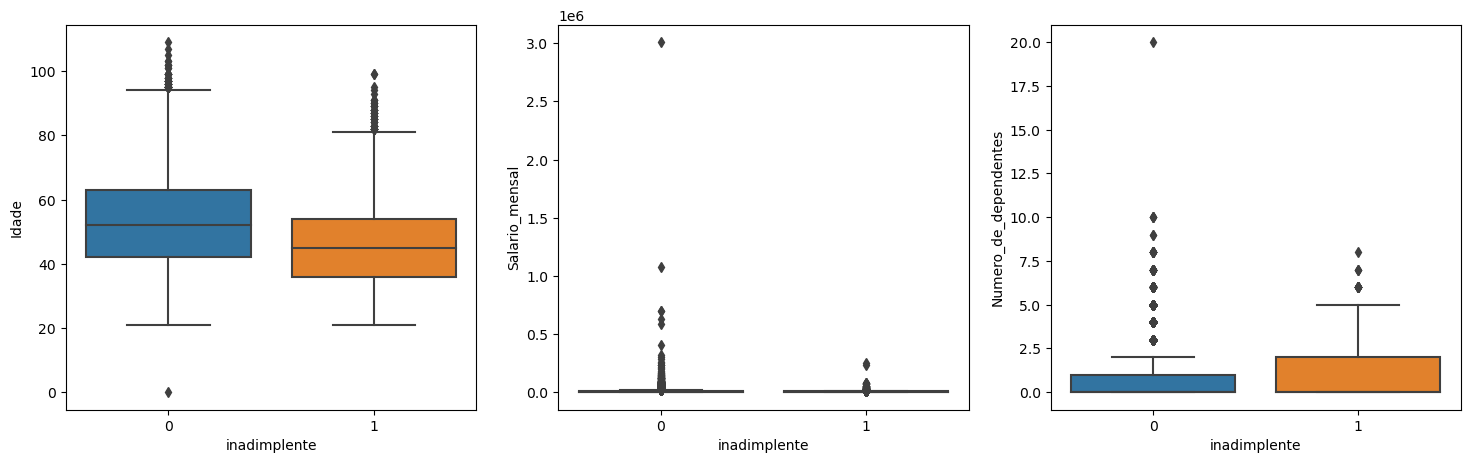

In [23]:
y_list = ["idade", "salario_mensal", "numero_de_dependentes"]    
make_boxplot_3axis("inadimplente", y_list, df_train_raw)

Removendo outliers para visualizar melhor. De forma intuitiva e apenas para fins de exploração, considerarei como outliers os registros localizados no final da distribuição de valores, no último percentil (=> 99%). No notebook de processamento de dados será feita uma análise quantitiva dos outliers!

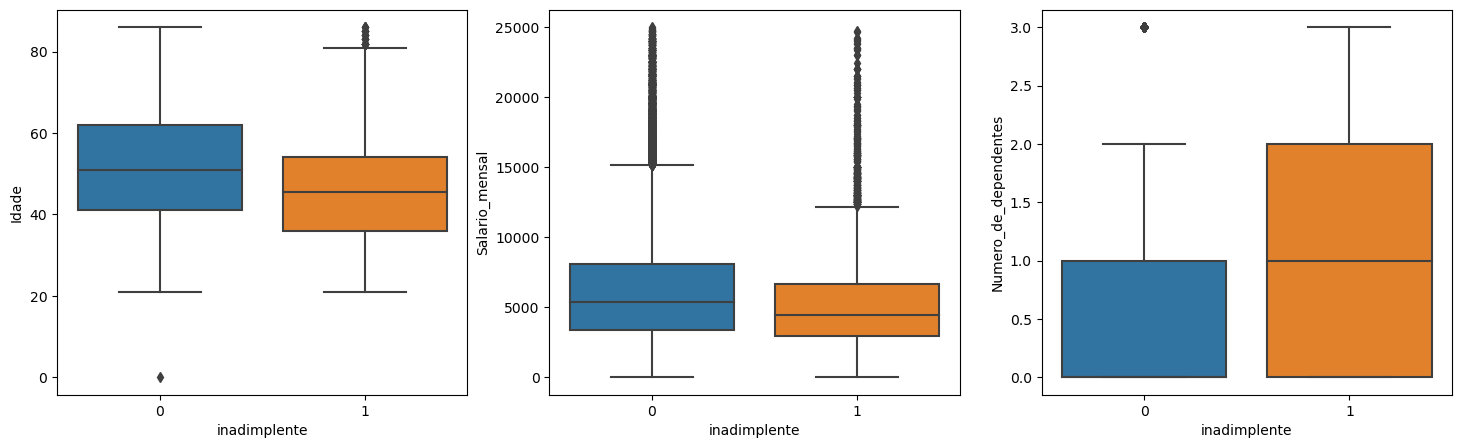

In [24]:
data_without_outliers = remove_outliers_in_last_percentile(y_list, df_train_raw)
make_boxplot_3axis("inadimplente", y_list, data_without_outliers)

Continuando exploração das hipóteses:

- 2.Clientes com mais empréstimos em aberto devem ser menos inadimplentes?
- 3.Clientes que atrasam menos devem ser menos inadimplentes?
- 4.Quando menor a razão dívida/patrimônio, menor a inadimplência?

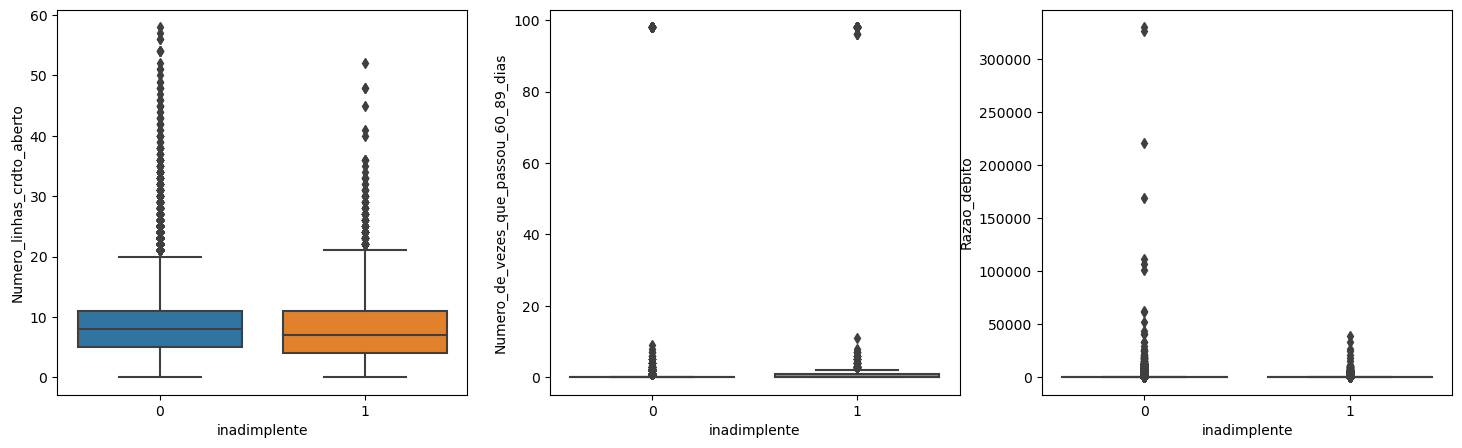

In [25]:
y_list = ["numero_linhas_crdto_aberto", "numero_de_vezes_que_passou_60_89_dias", "razao_debito"]    
make_boxplot_3axis("inadimplente", y_list, df_train_raw)

Abrindo o gráfico de distribuição por classe de inadimplência e removendo os outliers, se necessário:

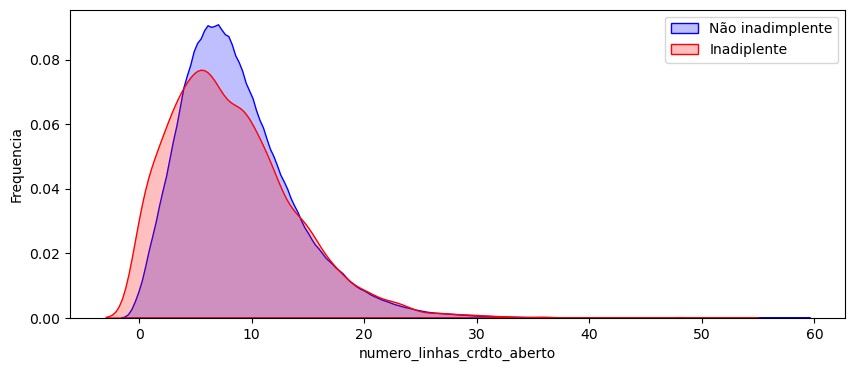

In [26]:
# Número de empréstimos
make_kdeplot_by_debt(y_list[0], df = data_without_outliers)

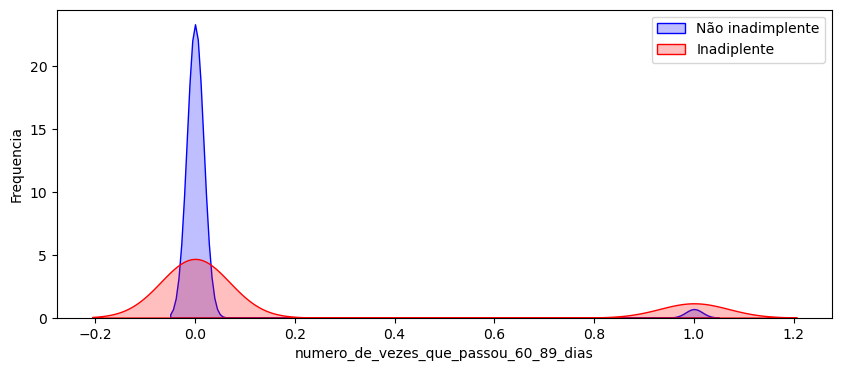

In [27]:
# Número de atrasos
data_without_outliers = remove_outliers_in_last_percentile(y_list, df_train_raw)
make_kdeplot_by_debt(y_list[1], df = data_without_outliers)

In [28]:
# Por que está aparecendo apenas valores entre 0 e 1?Investigando os últimos quantis!
# Pouca variação nos dados!Até percentil 98, apenas valores == 1
df_train_raw["numero_de_vezes_que_passou_60_89_dias"].quantile([0.95, 0.96, 0.97, 0.98, 0.99, 1.0])

0.95     1.0
0.96     1.0
0.97     1.0
0.98     1.0
0.99     2.0
1.00    98.0
Name: numero_de_vezes_que_passou_60_89_dias, dtype: float64

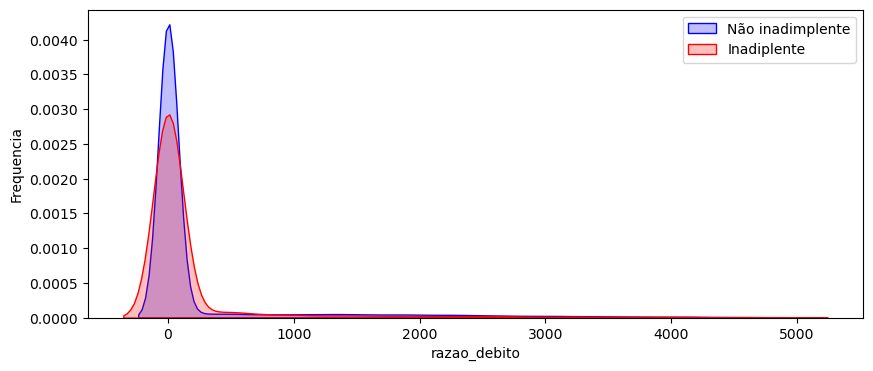

In [29]:
# Razão débito/patrimônio
data_without_outliers = remove_outliers_in_last_percentile(y_list, df_train_raw)
make_kdeplot_by_debt(y_list[2], df = data_without_outliers)

5.Quanto menos linhas seguras, maior a inadimplência?

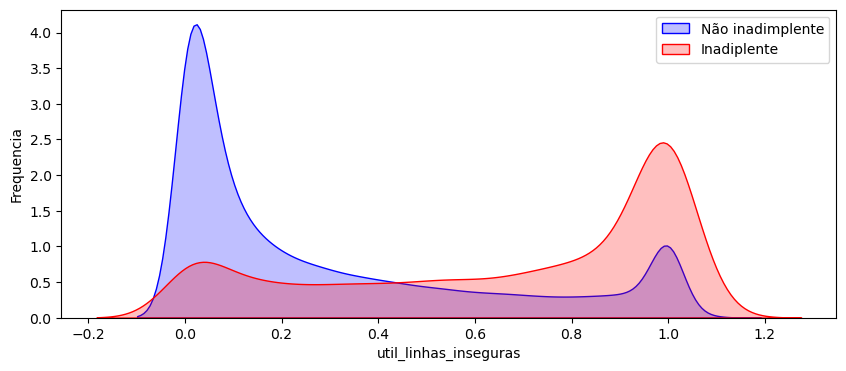

In [30]:
x = "util_linhas_inseguras"
data_without_outliers = remove_outliers_in_last_percentile([x], df_train_raw)
make_kdeplot_by_debt(x, data_without_outliers)

6.Quanto maior a renda, maior o número de empréstimos concedidos?

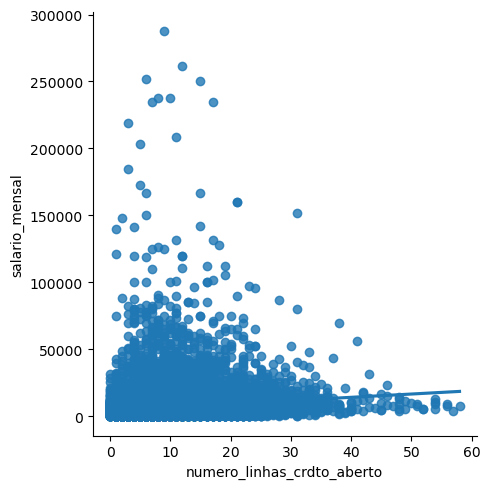

In [31]:
sns.lmplot(data=df_train_raw[df_train_raw["salario_mensal"] < 300000], ##remove oulier
           y="salario_mensal", 
           x="numero_linhas_crdto_aberto");

---

## 4 - Resumo da exploração de dados

**Estrutura dos dados:**
- Tamanho da base de treino: 110.000 registros
- Tamanho da base de teste: 40.000 registros
- Base de treino desbalanceada (93%N e 7%S)
- Apenas dados numéricos nas 2 bases
- Valores faltantes em 2 colunas: salário (20%) e n_dependentes (3%)
- 434 registros duplicados
- Pouca variação nas variáveis que representam número de atraso

--- 
**Estatística descritiva:**
- Registros com valores inconsistentes:
    * idade 0
    * linhas inseguras > 1

---
**Outliers:**
- razão débito
- salário mensal
- número de atrasos?

---
**Variáveis autocorrelacionadas:**
- Aquelas relacionadas ao número de vezes de atraso: manter apenas 1 delas

---
**Conclusão das hipóteses:**

```Não testei estatisticamente. Conclusões retiradas por critério visual!```
- Clientes mais velhores parecem ser mais adimplentes
- A média salarial de inadimplentes é menor do que adimplentes
- Clientes com mais dependentes parecem ser mais inadimplentes
- Não parece haver relação entre inadimplência e número de empréstimos tomados pelo cliente
- Clientes inadimplentes tendem a ter mais atrasos de pagamentos dos empréstimos
- Clientes inadimplentes têm menor razão débito (parece contra-intuitivo pra mim!). Por que isso ocorre?
- Clientes inadimplentes tem maior proporção de linhas inseguras
- Não existe relação entre salário e número de empréstimos tomados
